In [111]:
%pip install tensorflow keras

import numpy as np
import matplotlib.pyplot as plt
import pypianoroll
import pretty_midi
import pandas as pd
import os
from scipy import stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

  Using cached numpy-1.19.5-cp38-cp38-macosx_10_9_x86_64.whl (15.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.20.2
    Uninstalling numpy-1.20.2:
      Successfully uninstalled numpy-1.20.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pdpbox 0.2.1 requires matplotlib==3.1.1, but you have matplotlib 3.1.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


Removed files that did not have 2 tracks (some were broken, and some required
3 hands to play).

In [126]:
# Create empty dataframe that will store some data
df = pd.DataFrame(columns = ['name', 'game', 'resolution', 'tracks', 'length', 'index'])
print(d)
index = 0
midis = []
rolls = np.zeros((185,1000,128))
# Iterate over all folders 
for root, dirs, files in os.walk('Midis'):
    # Iterate over all midi files in folder
    for name in files:
        # Double check if midi file
        if (name[-3:] == "mid"):
            
            # Finds path, ex: Midis/WW/The Legend...mid
            path = os.path.join(root, name)
        
            # Load using pypianoroll and extract info
            mid = pypianoroll.read(path)
            mid.binarize()
            roll = mid[0].pianoroll + mid[1].pianoroll
            
            shap = (roll).shape
            if shap[0]>999:
                midis.append(mid)
                rolls[index,:,:] = roll[:1000,:128]
                res = mid.resolution
                tracks = len(mid.tracks)
                index+=1
                # Store info in pandas dataframe
                df = df.append({'name': name, 'resolution': res, 
                      'tracks': tracks, 'game': root, 'length': shap[0], 'index': index}, ignore_index=True)
df

{'name', 'resolution', 'tracks', 'game', 'index'}


/usr/local/lib/python3.8/site-packages/pretty_midi/pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


,name,game,resolution,tracks,length,index
0,The Legend of Zelda A Link to the Past - Trifo...,Midis/ALttP,24,2,3696,1
1,The Legend of Zelda A Link to the Past - Boss ...,Midis/ALttP,24,2,3384,2
2,The Legend of Zelda A Link to the Past - Hyrul...,Midis/ALttP,24,2,8928,3
3,The Legend of Zelda A Link to the Past - Overw...,Midis/ALttP,24,2,4224,4
4,The Legend of Zelda A Link to the Past - Lost ...,Midis/ALttP,24,2,2304,5
...,...,...,...,...,...,...
153,The Legend of Zelda Four Swords Adventures - T...,Midis/FSA,24,2,2304,154
154,The Legend of Zelda Four Swords Adventures - L...,Midis/FSA,24,2,2688,155
155,The Legend of Zelda Four Swords Adventures - D...,Midis/FSA,24,2,4608,156
156,The Legend of Zelda Four Swords Adventures - M...,Midis/FSA,24,2,4800,157


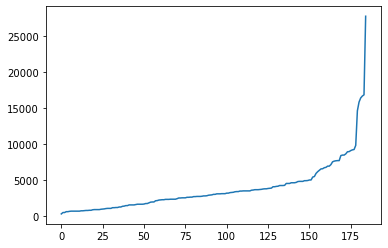

In [119]:
plt.plot(np.sort(df['length']))
plt.show()

In [65]:
for index, row in df.iterrows():
    print("==============")
    print(df['name'][index])
    print(stats.mode(midis[index].tempo))
    print(np.mean(midis[index].tempo))
    print("==============")

The Legend of Zelda A Link to the Past - Triforce Chamber.mid
ModeResult(mode=array([[119.00016065]]), count=array([[960]]))
118.16943655257052
The Legend of Zelda A Link to the Past - Boss Battle.mid
ModeResult(mode=array([[191.0000764]]), count=array([[1200]]))
190.94123912866408
The Legend of Zelda A Link to the Past - Hyrule Castle.mid
ModeResult(mode=array([[131.00007642]]), count=array([[4848]]))
130.3926162703103
The Legend of Zelda A Link to the Past - Overworld.mid
ModeResult(mode=array([[135.000135]]), count=array([[1632]]))
134.92862015214104
The Legend of Zelda A Link to the Past - Lost Woods.mid
ModeResult(mode=array([[139.00021777]]), count=array([[1248]]))
138.7380436693283
The Legend of Zelda A Link to the Past - Dark World.mid
ModeResult(mode=array([[131.00007642]]), count=array([[4560]]))
130.87856085900395
The Legend of Zelda A Link to the Past - Title Screen.mid
ModeResult(mode=array([[89.00004005]]), count=array([[264]]))
96.9969236981345
The Legend of Zelda A Link

142.9538877527255
The Legend of Zelda Four Swords Adventures - The Terrace of the Two People.mid
ModeResult(mode=array([[75.]]), count=array([[1176]]))
74.88438170216806
The Legend of Zelda Four Swords Adventures - Light Overworld.mid
ModeResult(mode=array([[132.000132]]), count=array([[1224]]))
132.00013200013174
The Legend of Zelda Four Swords Adventures - Dampe's Cabin.mid
ModeResult(mode=array([[151.0003775]]), count=array([[2688]]))
151.0003775009432
The Legend of Zelda Four Swords Adventures - Main Theme.mid
ModeResult(mode=array([[69.96007612]]), count=array([[2496]]))
69.75613794768233
The Legend of Zelda Four Swords Adventures - Realm of Heaven.mid
ModeResult(mode=array([[133.00024162]]), count=array([[3672]]))
133.0002416171057


Build supersimple encoder

In [154]:
import keras
from keras import layers

from keras import regularizers

rolls= rolls.reshape(185,1000*128)
rolls_train = rolls[:100,:]
rolls_test = rolls[101:,:]

encoding_dim = 128

input_img = keras.Input(shape=(1000*128,))
encoded = layers.Dense(512, activation='relu')(input_img)
encoded = layers.Dense(256, activation='relu')(encoded)
encoded = layers.Dense(128, activation='relu')(encoded)

decoded = layers.Dense(256, activation='relu')(encoded)
decoded = layers.Dense(512, activation='relu')(decoded)
decoded = layers.Dense(1000*128, activation='sigmoid')(decoded)
autoencoder = keras.Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(rolls, rolls,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(rolls, rolls))


Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.6932 - val_loss: 0.6928
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 0.6928 - val_loss: 0.6916
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 0.6916 - val_loss: 0.6813
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 0.6813 - val_loss: 0.6119
Epoch 5/100
1/1 [==============================] - 1s 1s/step - loss: 0.6119 - val_loss: 0.4068
Epoch 6/100
1/1 [==============================] - 1s 1s/step - loss: 0.4068 - val_loss: 0.2177
Epoch 7/100
1/1 [==============================] - 1s 1s/step - loss: 0.2177 - val_loss: 0.2309
Epoch 8/100
1/1 [==============================] - 1s 1s/step - loss: 0.2309 - val_loss: 0.2683
Epoch 9/100
1/1 [==============================] - 1s 1s/step - loss: 0.2683 - val_loss: 0.2600
Epoch 10/100
1/1 [==============================] - 1s 1s/step - loss: 0.2600 - val_loss: 0.2401
Epoch 11/100
1/1 [=====================

1/1 [==============================] - 2s 2s/step - loss: 0.0569 - val_loss: 0.0568
Epoch 86/100
1/1 [==============================] - 2s 2s/step - loss: 0.0568 - val_loss: 0.0565
Epoch 87/100
1/1 [==============================] - 2s 2s/step - loss: 0.0565 - val_loss: 0.0563
Epoch 88/100
1/1 [==============================] - 2s 2s/step - loss: 0.0563 - val_loss: 0.0561
Epoch 89/100
1/1 [==============================] - 2s 2s/step - loss: 0.0561 - val_loss: 0.0560
Epoch 90/100
1/1 [==============================] - 2s 2s/step - loss: 0.0560 - val_loss: 0.0557
Epoch 91/100
1/1 [==============================] - 2s 2s/step - loss: 0.0557 - val_loss: 0.0555
Epoch 92/100
1/1 [==============================] - 1s 1s/step - loss: 0.0555 - val_loss: 0.0553
Epoch 93/100
1/1 [==============================] - 1s 1s/step - loss: 0.0553 - val_loss: 0.0551
Epoch 94/100
1/1 [==============================] - 1s 1s/step - loss: 0.0551 - val_loss: 0.0548
Epoch 95/100
1/1 [=========================

In [155]:
# Encode and decode some digits
# Note that we take them from the *test* set
decoded_imgs = autoencoder.predict(rolls)

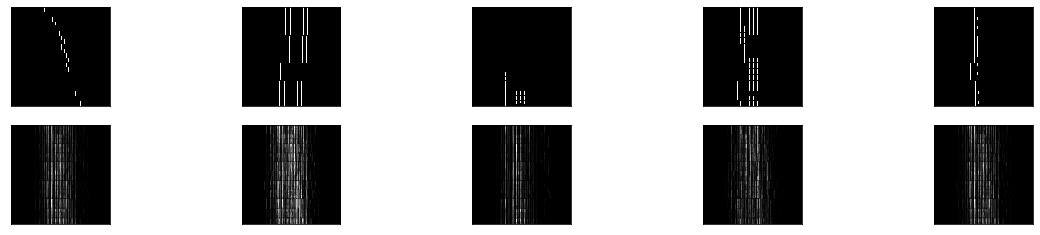

In [157]:
n = 5  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(rolls[i].reshape(1000, 128)[:128,:])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(1000, 128)[:128,:])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()